# Контрольная работа по теме "Классификация текста"
Выполнил: Пакало Александр Сергеевич ИУ5-22М

## Задание
Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать два варианта векторизации признаков - на основе CountVectorizer и на основе TfidfVectorizer.

В качестве классификаторов необходимо использовать два классификатора по варианту для Вашей группы: RandomForestClassifier, LogisticRegression

In [1]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [38]:
# Reloading editable packages.
%autoreload
from charts.main import grouped_bar_chart, get_metrics_grouped_bar_chart

In [3]:
RANDOM_SEED = 13

## Набор данных
Проведём классификацию текста используя набор данных [BBC News Archive](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)

Подготовка переменных для работы с данными

In [4]:
from pathlib import Path

data_path = Path("../../data")
external_data_path = data_path / "external"
raw_data_path = data_path / "raw"

dataset_filename = "bbc-news-data.zip"

Разархивирование набора данных

In [5]:
import os
import shutil

raw_data_path.mkdir(exist_ok=True)

file_path = external_data_path / dataset_filename
raw_data_path = external_data_path / dataset_filename

if not os.path.isfile(raw_data_path):
    shutil.unpack_archive(file_path, extract_dir=raw_data_path)
    # file_path.unlink()  # Remove archive after extracting it.

Загрузка данных из csv

In [6]:
import pandas as pd

df = pd.read_csv(raw_data_path, sep="\t")

### Разведочный анализ данных
Ознакомимся немного с данными, с которыми собираемся работать

Основные характеристики датасета

In [7]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [8]:
df.tail()

,category,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


Размер датасета

In [9]:
num_of_rows, num_of_columns = df.shape
print(f'Размер датасета: {num_of_rows} строк, {num_of_columns} колонок')

Размер датасета: 2225 строк, 4 колонок


Определение типов

In [10]:
df.dtypes

category    object
filename    object
title       object
content     object
dtype: object

Проверка на наличие пустых значений

In [11]:
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

Обработки пустых значений не требуется

Проверка на уникальные значения

In [12]:
pd.Series(df["category"].unique())

0         business
1    entertainment
2         politics
3            sport
4             tech
dtype: object

### Подготовка корпуса

Некоторые колонки имеют неверные типы данных, их следует преобразовать.

Строки вместо `object` сделаем `string`, а колонку "category" сделаем
типа `category`.

In [13]:
df = df.astype({
    "category": "category",
    "filename": "string",
    "title": "string",
    "content": "string",
})
df.dtypes

category          category
filename    string[python]
title       string[python]
content     string[python]
dtype: object

Токенизация

Загрузка модели spacy.

In [14]:
import spacy

spacy_prefers_gpu = spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

Токенизация текстовых значений набора данных (кроме названия файла)

In [15]:
from spacy.tokens.doc import Doc

corpus: list[Doc] = []

for text in (df["title"] + df["content"]).values:
    corpus.append(nlp(text))

corpus[:3]

[Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

In [16]:
assert len(corpus) == num_of_rows

## Классификация

### Подготовка данных для классификации

Заметим, что хоть spacy при печати и выводит текст, на самом деле это объект.
Наши модели ожидают увидеть строки.

In [17]:
spacy_text = nlp('training: nlp!')
spacy_text, type(spacy_text), type(spacy_text[0])

(training: nlp!, spacy.tokens.doc.Doc, spacy.tokens.token.Token)

In [18]:
[token.text for token in spacy_text]

['training', ':', 'nlp', '!']

Поэтому преобразуем наш `corpus` в упрощённый формат, совместимый с word2vec.

In [19]:
str_corpus = [spacy_text.text for spacy_text in corpus]

Выберем `X` и `y` среди нашего набора данных

In [20]:
X = str_corpus
y = df["category"].values

Составим выборки для обучения

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=RANDOM_SEED
)

### Составим pipeline

In [22]:
import numpy as np
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score


def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """

    accs = accuracy_score_for_classes(y_true, y_pred)
    results = pd.DataFrame(data={ "Категория": accs.keys(), "Точность": accs.values() })

    display(results)

    return results

In [23]:
class EmbeddingVectorizer(object):
    '''
    Для текста усредним вектора входящих в него слов
    '''
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean(
            [self.model[w] for w in words if w in self.model] 
            or [np.zeros(self.size)], axis=0)
            for words in X])

In [24]:
from sklearn.pipeline import Pipeline


def classifier_pipeline(v, c, scaler=None):
    pipeline_steps = [
        ("vectorizer", v), 
    ]

    if scaler:
        pipeline_steps.append(("scaler", scaler))

    pipeline_steps.append(("classifier", c))

    pipeline = Pipeline(pipeline_steps)

    classifier_X_train = X_train
    classifier_y_train = y_train
    classifier_X_test = X_test
    classifier_y_test = y_test

    pipeline.fit(classifier_X_train, classifier_y_train)
    y_pred = pipeline.predict(classifier_X_test)

    return print_accuracy_score_for_classes(classifier_y_test, y_pred)

### Проверка результатов

In [53]:
ClassifierName = str
ModelName = str
CategoryName = str

# For seeing results of each category for each classifier.
MetricsDataPerCategory = dict[ClassifierName, dict[CategoryName, float]] 
metrics_data_per_category: MetricsDataPerCategory = {}

# For seeing general results of each classifier for each model (category
# metrics are generalized then).
MetricsDataPerModel = dict[ClassifierName, dict[ModelName, float]] 
metrics_data_per_model: MetricsDataPerModel = {}

In [54]:
def add_metrics_data(classier_name: ClassifierName, model_name: ModelName, results: pd.DataFrame):
    if not metrics_data_per_model.get(classier_name):
        metrics_data_per_model[classier_name] = {}

    metrics_data_per_model[classier_name][model_name] = np.mean(results['Точность'])

    results_per_category = dict(zip(results["Категория"], results["Точность"]))
    metrics_data_per_category[classier_name] = results_per_category

    return metrics_data_per_model, metrics_data_per_category

### CountVectorizer
Scaler не нужен (и его даже невозможно применить, ведь CountVectorizer возвращает
разреженную матрицу)

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,3))

#### LogisticRegression

In [56]:
add_metrics_data("LogisticRegression", "count vectorizer", classifier_pipeline(count_vectorizer, LogisticRegression(C=5.0)))

,Категория,Точность
0,business,0.968553
1,entertainment,0.912409
2,politics,0.942446
3,sport,0.993711
4,tech,0.921986


({'LogisticRegression': {'count vectorizer': 0.9478209537671576}},
 {'LogisticRegression': {'business': 0.9685534591194969,
   'entertainment': 0.9124087591240876,
   'politics': 0.9424460431654677,
   'sport': 0.9937106918238994,
   'tech': 0.9219858156028369}})

#### RandomForestClassifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

add_metrics_data("RandomForestClassifier", "count vectorizer", classifier_pipeline(count_vectorizer, RandomForestClassifier(max_depth=200, criterion="gini")))

,Категория,Точность
0,business,0.981132
1,entertainment,0.868613
2,politics,0.863309
3,sport,1.000000
4,tech,0.879433


({'LogisticRegression': {'count vectorizer': 0.9478209537671576},
  'RandomForestClassifier': {'count vectorizer': 0.9184974381578581}},
 {'LogisticRegression': {'business': 0.9685534591194969,
   'entertainment': 0.9124087591240876,
   'politics': 0.9424460431654677,
   'sport': 0.9937106918238994,
   'tech': 0.9219858156028369},
  'RandomForestClassifier': {'business': 0.9811320754716981,
   'entertainment': 0.8686131386861314,
   'politics': 0.8633093525179856,
   'sport': 1.0,
   'tech': 0.8794326241134752}})

#### Сравнение результатов классификаторов для каждой категории

In [58]:
def show_classifiers_bar_chart(metrics_data_per_category: MetricsDataPerCategory):
    classifiers_bar_chart = get_metrics_grouped_bar_chart(metrics_data_per_category)
    classifiers_bar_chart["plt"].title('Сравнение классификаторов для каждой категории')
    classifiers_bar_chart["plt"].xlabel('Категория')
    classifiers_bar_chart["plt"].ylabel('Значение метрики')

    classifiers_bar_chart["ax"].legend(title='Классификатор', bbox_to_anchor=(1.2, 1))

    classifiers_bar_chart["plt"].show()

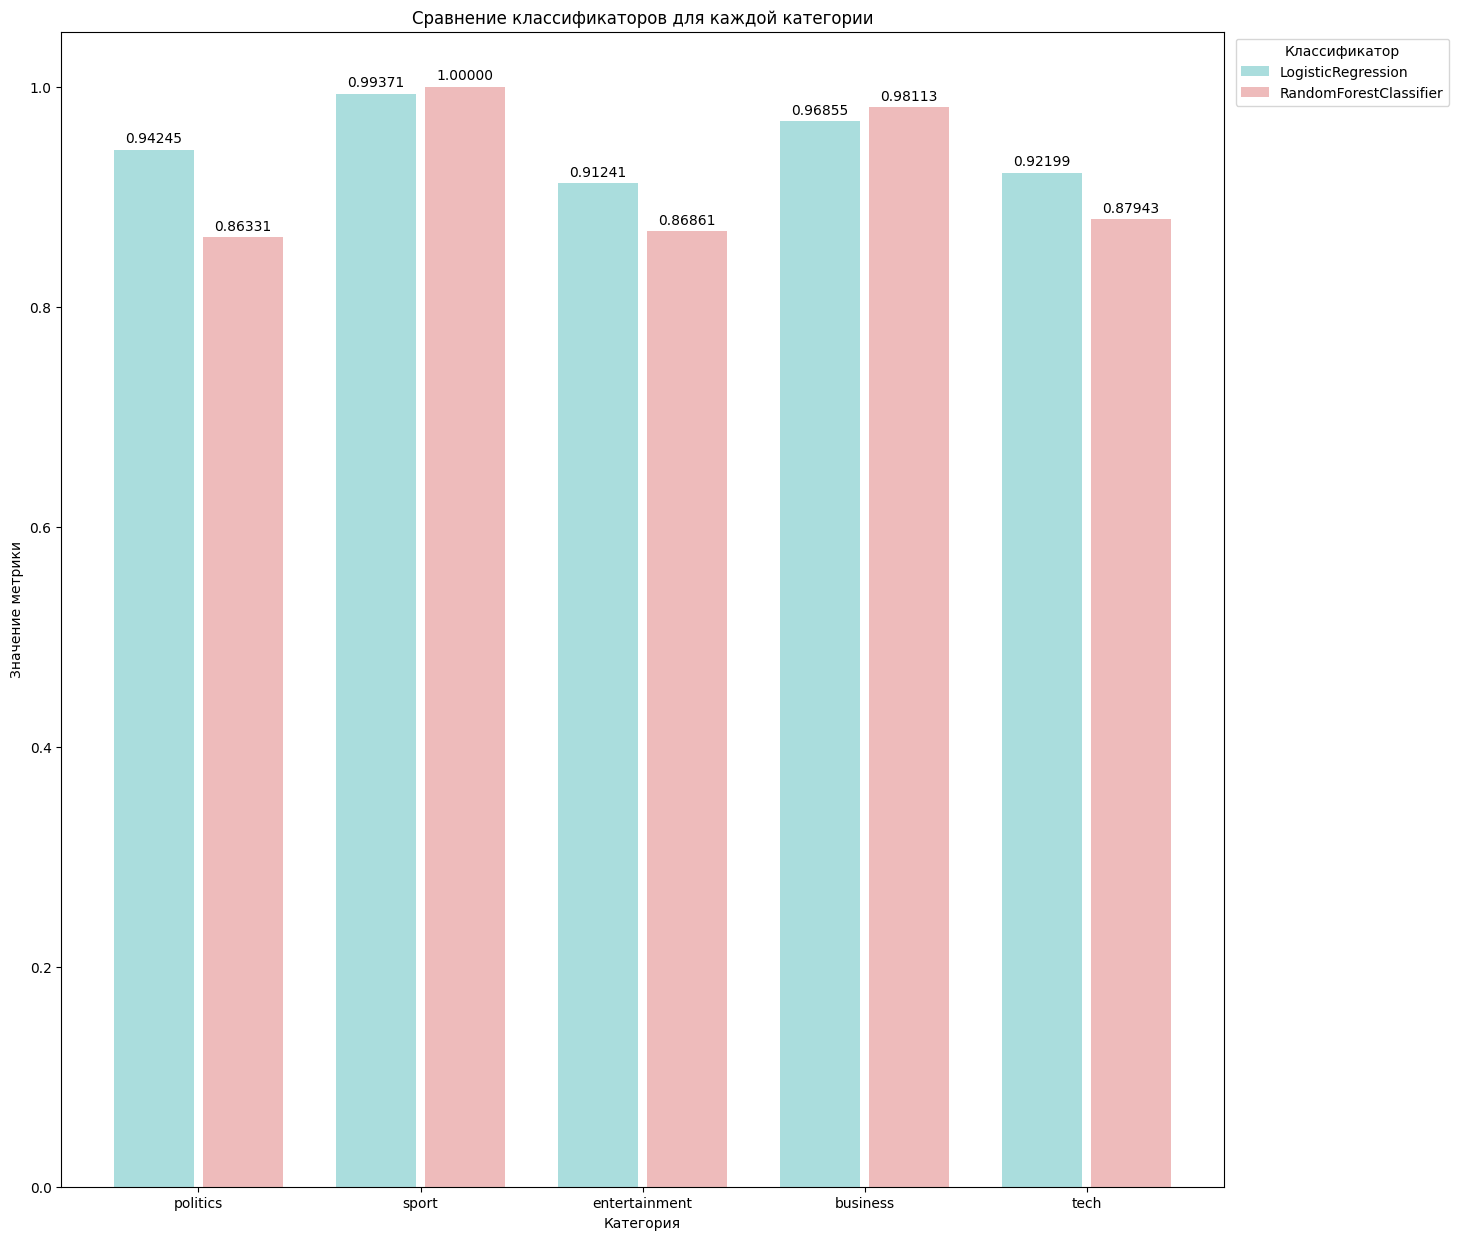

In [59]:
show_classifiers_bar_chart(metrics_data_per_category)

### TFIDF
Scaler не нужен (и его даже невозможно применить, ведь tfidf возвращает
разреженную матрицу)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,3))

#### LogisticRegression

In [61]:
add_metrics_data("LogisticRegression", "tfidf", classifier_pipeline(tfidf, LogisticRegression(C=5.0)))

,Категория,Точность
0,business,0.955975
1,entertainment,0.919708
2,politics,0.971223
3,sport,0.993711
4,tech,0.992908


({'LogisticRegression': {'count vectorizer': 0.9478209537671576,
   'tfidf': 0.9667048773578898},
  'RandomForestClassifier': {'count vectorizer': 0.9184974381578581}},
 {'LogisticRegression': {'business': 0.9559748427672956,
   'entertainment': 0.9197080291970803,
   'politics': 0.9712230215827338,
   'sport': 0.9937106918238994,
   'tech': 0.9929078014184397},
  'RandomForestClassifier': {'business': 0.9811320754716981,
   'entertainment': 0.8686131386861314,
   'politics': 0.8633093525179856,
   'sport': 1.0,
   'tech': 0.8794326241134752}})

#### RandomForestClassifier

In [62]:
from sklearn.ensemble import RandomForestClassifier

add_metrics_data("RandomForestClassifier", "tfidf", classifier_pipeline(tfidf, RandomForestClassifier(max_depth=200, criterion="gini")))

,Категория,Точность
0,business,0.968553
1,entertainment,0.795620
2,politics,0.877698
3,sport,0.993711
4,tech,0.843972


({'LogisticRegression': {'count vectorizer': 0.9478209537671576,
   'tfidf': 0.9667048773578898},
  'RandomForestClassifier': {'count vectorizer': 0.9184974381578581,
   'tfidf': 0.8959108123663786}},
 {'LogisticRegression': {'business': 0.9559748427672956,
   'entertainment': 0.9197080291970803,
   'politics': 0.9712230215827338,
   'sport': 0.9937106918238994,
   'tech': 0.9929078014184397},
  'RandomForestClassifier': {'business': 0.9685534591194969,
   'entertainment': 0.7956204379562044,
   'politics': 0.8776978417266187,
   'sport': 0.9937106918238994,
   'tech': 0.8439716312056738}})

#### Сравнение результатов классификаторов для каждой категории

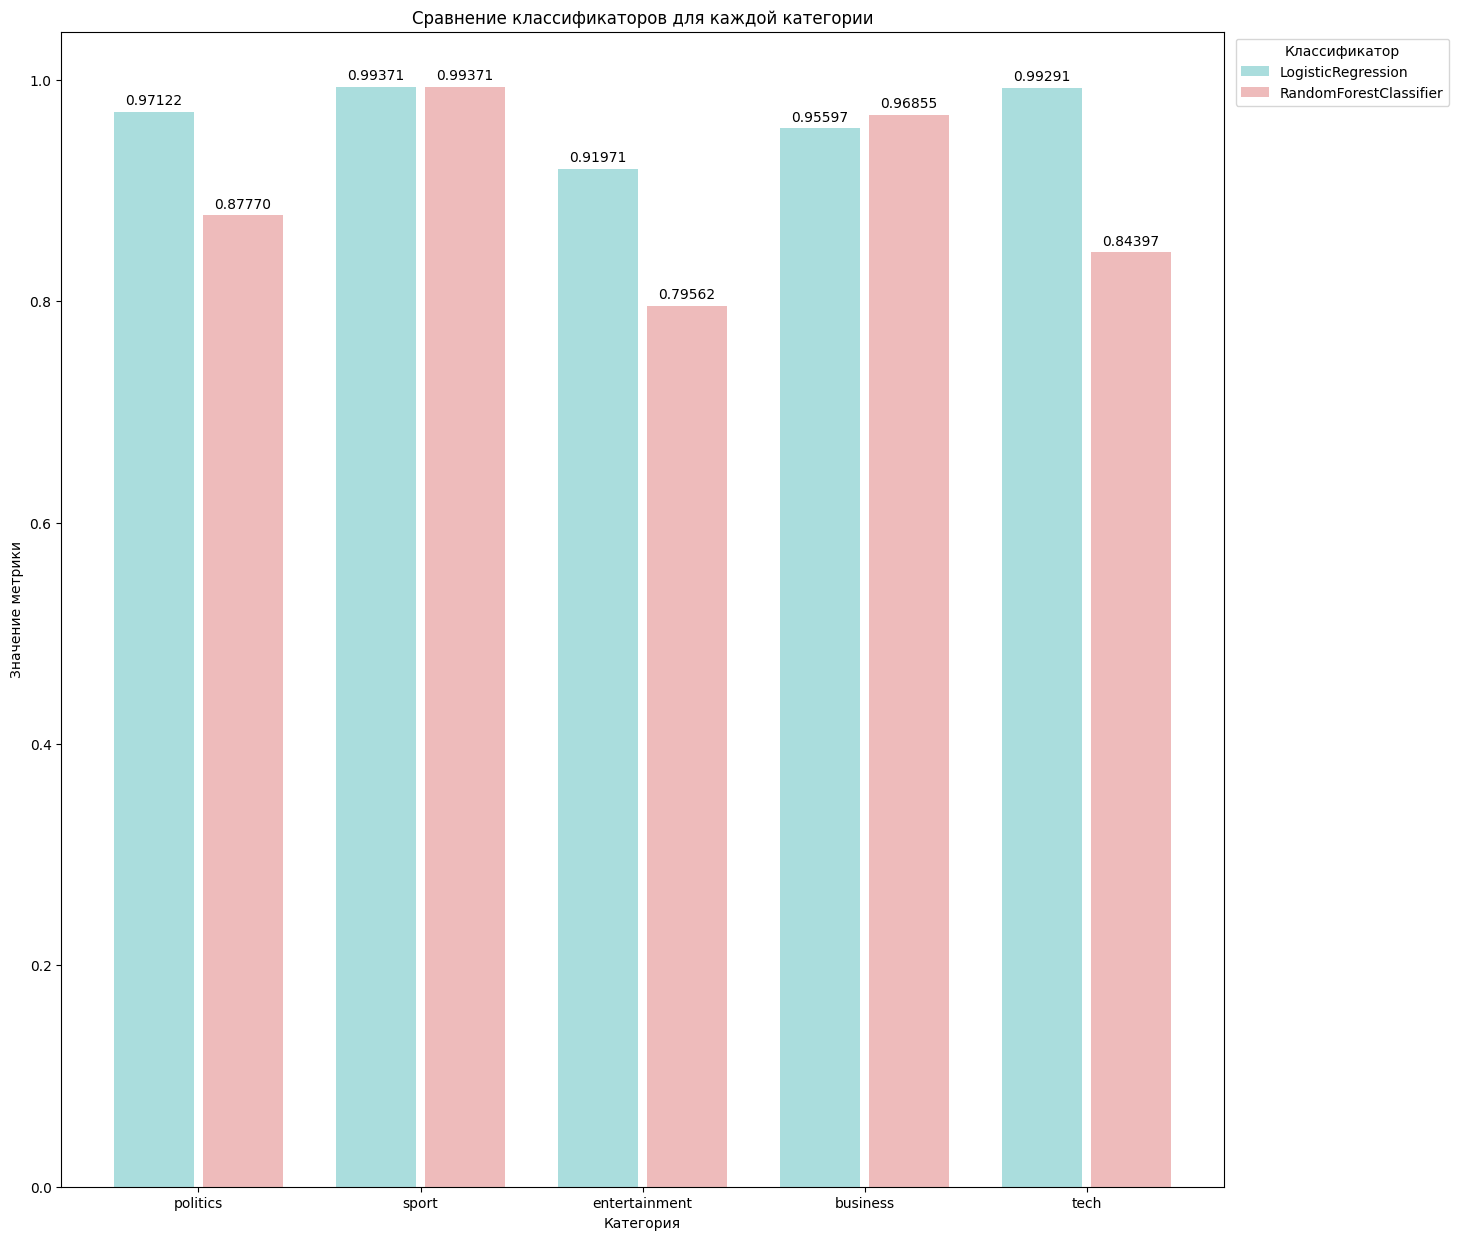

In [63]:
show_classifiers_bar_chart(metrics_data_per_category)

### Сравнение результатов моделей и классификаторов

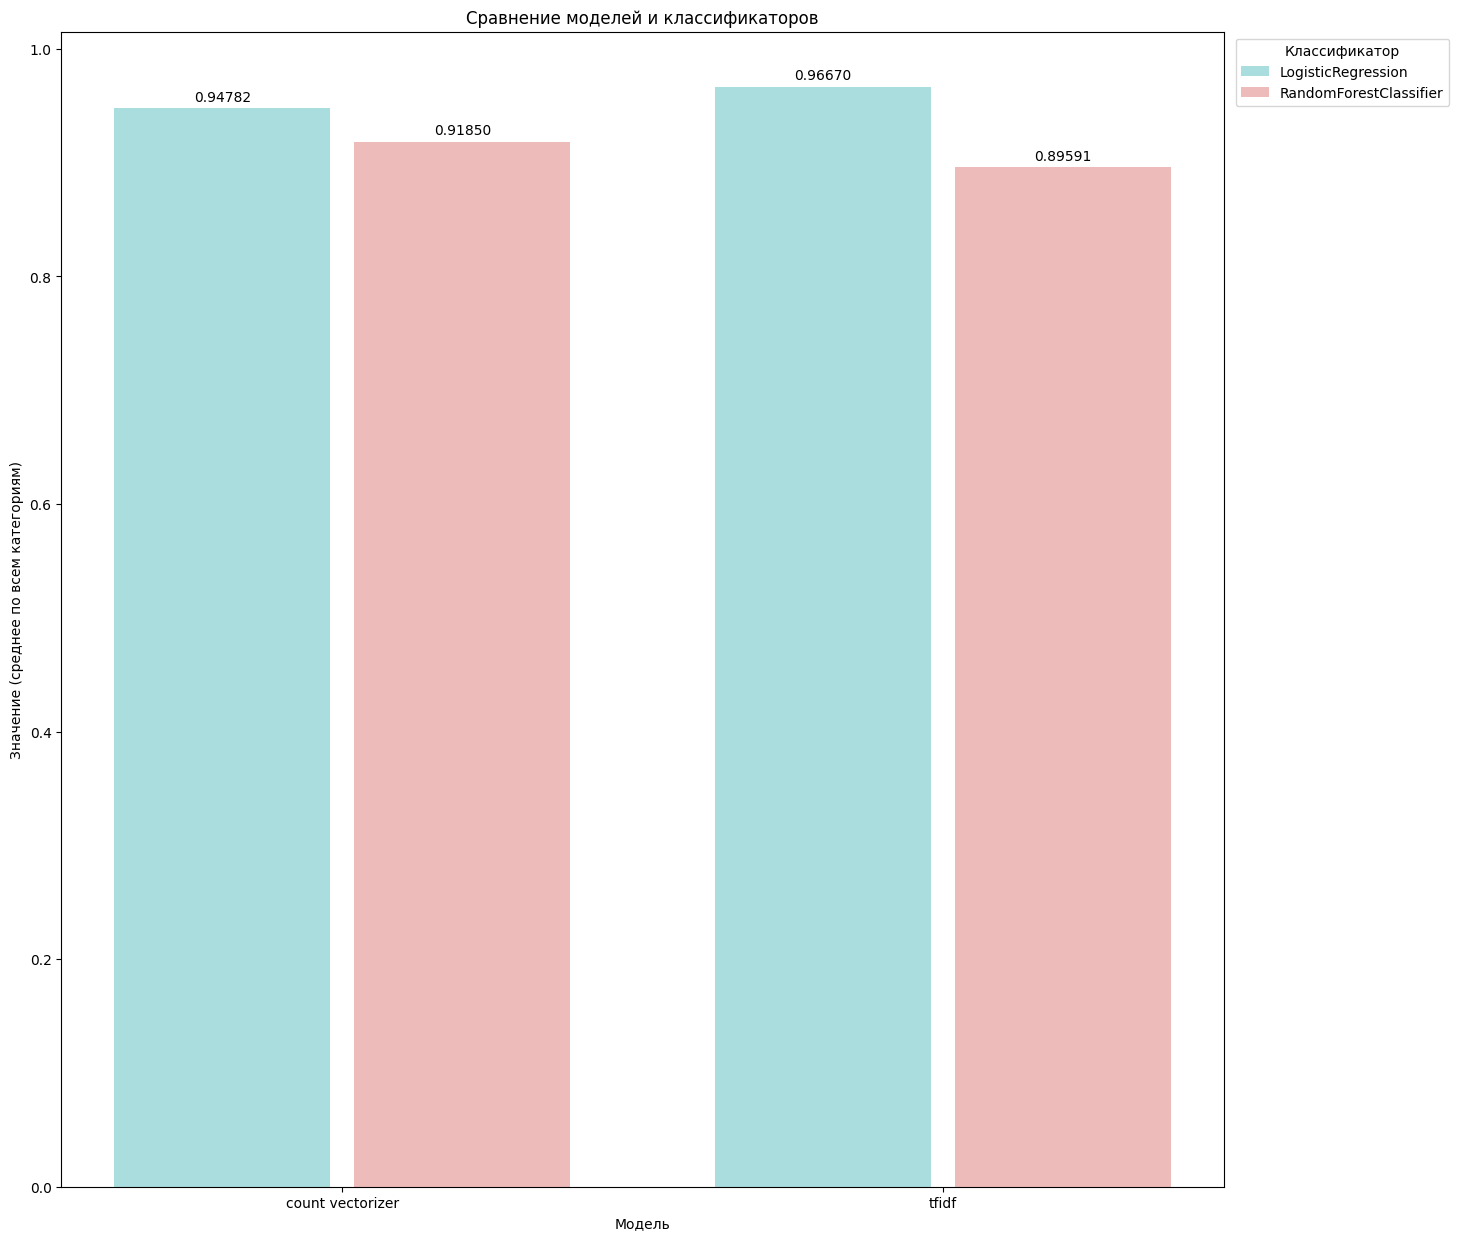

In [65]:
models_bar_chart = get_metrics_grouped_bar_chart(metrics_data_per_model)
models_bar_chart["plt"].title('Сравнение моделей и классификаторов')
models_bar_chart["plt"].xlabel('Модель')
models_bar_chart["plt"].ylabel('Значение (среднее по всем категориям)')

models_bar_chart["ax"].legend(title='Классификатор', bbox_to_anchor=(1.2, 1))

models_bar_chart["plt"].show()

## Вывод
Как видно по графику сравнения моделей и классификаторов, наиболее успешной оказалась связка TFIDF и LogisticRegression.

В общем, значения моделей с классификатором логистистической регрессии выше на 5%, чем у соответствующих моделей с RandomForestClassifier.

При этом значения моделей при одинаковых классификаторах почти не отличаются: и TFIDF, и CountVectorizer демонстрируют хорошие результаты.